In [1]:
from os import listdir
from os.path import join, isfile
import numpy as np #1.16.4 otherwise futurewarning tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
import cv2

In [2]:
NUM_CLASSES = 11
BATCH_SIZE = 8
NUM_POINTS = 510

# Data

In [3]:
def load_data():
    data = []
    labels = []

    GENERAL_DIR = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien" 
    syn_list = ['ADNP', 'ANKRD11', 'CDK13', 'DEAF1', 'DYRK1A', 'EHMT1', 'FBXO11', 'SON', 'WAC', 'YY1', 'KDVS']
    file = GENERAL_DIR+ "\\features_facereader_landmarks_patient_groups.csv"
    class_map = {}
    
    for index, syn in enumerate(syn_list):
        class_map[index] = syn
        
        files = [f for f in listdir(GENERAL_DIR +"\\{}\\{}-all-photos".format(syn, syn)) if "jpg" in f]

        with open(file, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for row in reader:
                if row[0] in files:
                    fr_rep = [float(f) for f in row[1:]]
                    if not all(v == 0 for v in fr_rep):

                        rep = []
                        i = 1
                        while i < len(row[1:]):
                            rep.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                            i+=3  
                        data.append(rep)
                        labels.append(index)
                        
    
    return np.array(data), np.array(labels), class_map

In [4]:
def augment(points, label):
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    points = tf.random.shuffle(points)
    return points, label

(221, 510, 3)
(221,)


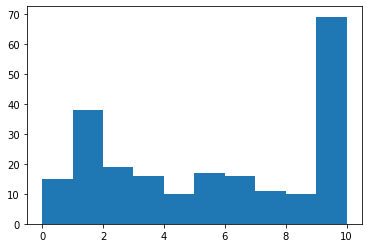

In [5]:
data, labels, class_map = load_data()

print(data.shape)
print(labels.shape)

plt.hist(labels)
plt.show()

# Model

In [6]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding='valid')(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [7]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)
        
    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2,2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [8]:
def tnet(inputs, num_features):
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features, 
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg)(x)
    
    feat_T = layers.Reshape((num_features, num_features))(x)
    
    return layers.Dot(axes=(2,1))([inputs, feat_T])

In [9]:
# model

def generate_model():

    inputs = keras.Input(shape=(NUM_POINTS, 3))

    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(rate=0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(rate=0.3)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    #model.summary()

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(lr=0.001),
        metrics=["sparse_categorical_accuracy"])
    
    return model

# Training

In [12]:
predictions = []
predictions_probs = []

loo = LeaveOneOut()
i = 0
for train_index, test_index in tqdm(loo.split(data)):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    model = generate_model()
       
    print(X_train.shape)
    print(type(X_train))
    print(type(X_train[0]))
    print(type(X_train[0][0]))

    model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=10, shuffle=True)
    
    y_pred_array = model.predict(X_test)
    y_pred = tf.math.argmax(y_pred_array, -1).numpy()
    
    predictions.append([y_test[0], y_pred[0]])
    predictions_probs.append([y_test[0], y_pred_array[0]])
        
    i+=1
    

0it [00:00, ?it/s]

(220, 510, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/10


0it [00:04, ?it/s]


KeyboardInterrupt: 

In [ ]:

confusion_matrix = np.zeros((11, 11))


for [true, pred] in predictions:
    confusion_matrix[pred][true] += 1
    

plt.figure()
plt.imshow(confusion_matrix)
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.colorbar()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_true, y_probs = [], []

for [true, pred] in predictions_probs:
    y_true.append(true)
    y_probs.append(pred)

In [ ]:
print(y_true)
print(y_probs)

In [ ]:
macro_roc_auc_ovo = roc_auc_score(y_true, y_probs, multi_class="ovo", average="macro", labels=[0,1,2,3,4,5,6,7,8,9,10])
weighted_roc_auc_ovo = roc_auc_score(y_true, y_probs, multi_class="ovo", average="weighted", labels=[0,1,2,3,4,5,6,7,8,9,10])
macro_roc_auc_ovr = roc_auc_score(y_true, y_probs, multi_class="ovr", average="macro", labels=[0,1,2,3,4,5,6,7,8,9,10])
weighted_roc_auc_ovr = roc_auc_score(y_true, y_probs, multi_class="ovr", average="weighted", labels=[0,1,2,3,4,5,6,7,8,9,10])

print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))

print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))